In [28]:
from typing import List, Tuple, Any
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3080


## Prepare Dataset

In [29]:
class BCIDataset(Dataset):
    _data_files: List[str]
    _data_loaded: bool = False

    _data: np.ndarray
    _labels: np.ndarray

    def __init__(
        self, data_files: List[str] = ["S4b_train.npz", "X11b_train.npz"]
    ):
        super(BCIDataset, self).__init__()
        for file in data_files:
            if not os.path.exists(file):
                raise FileNotFoundError(f"The data file {file} does not exist.")
        
        self._data_files = data_files

    def __len__(self):
        # lazy loading
        if not self._data_loaded:
            self._load_data()

        return self._labels.shape[0]

    def __getitem__(self, index: int) -> Tuple[torch.Tensor]:
        # lazy loading
        if not self._data_loaded:
            self._load_data()

        return torch.from_numpy(self._data[index]), self._labels[index]

    def _load_data(self):
        data = []
        labels = []

        for file in self._data_files:
            with np.load(file) as f:
                data.append(f["signal"])
                labels.append(f["label"])

        self._data = np.concatenate(data, axis = 0)
        self._labels = np.concatenate(labels, axis = 0)

        self._data = np.expand_dims(self._data, axis=1).swapaxes(-1, -2)
        self._labels -= 1

        mask = np.where(np.isnan(self._data))
        self._data[mask] = np.nanmean(self._data)

        self._data_loaded = True

train_dataset = BCIDataset(data_files = ["S4b_train.npz", "X11b_train.npz"])
test_dataset = BCIDataset(data_files = ["S4b_test.npz", "X11b_test.npz"])

## Build Models

In [3]:
class Model(nn.Module):
    _activation_dict = {
        "ELU": lambda: nn.ELU(alpha = 1.0),
        "ReLU": lambda: nn.ReLU(),
        "LeakyReLU": lambda: nn.LeakyReLU(negative_slope = 0.01)
    }
    _activation_name: str

    def __init__(self, activation: str):
        super(Model, self).__init__()
        if activation not in self._activation_dict:
            raise NotImplementedError(f"The activation function {activation} is not implemented.")

        self.activation = None
        self._activation_name = activation

    @property
    def activation(self) -> nn.Module:
        return self._activation_dict[self._activation_name]()

    @activation.setter
    def activation(self, _):
        pass

### EEGNet

#### Architecture
![EEGNet](assets/EEGNet.jpg)

In [4]:
class EEGNet(Model):
    first_conv: nn.Sequential
    depthwise_conv: nn.Sequential
    separable_conv: nn.Sequential
    classfier: nn.Sequential

    def __init__(self, activation: str = "ELU", dropout: float = 0.25, bias: bool = False):
        super(EEGNet, self).__init__(activation)

        self.first_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = (1, 51), stride = (1, 1), padding = (0, 25), bias = False),
            nn.BatchNorm2d(16, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True)
        )
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = (2, 1), stride = (1, 1), groups = 16, bias = bias),
            nn.BatchNorm2d(32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True),
            self.activation,
            nn.AvgPool2d(kernel_size = (1, 4), stride = (1, 4), padding = 0),
            nn.Dropout(p = dropout)
        )
        self.separable_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = (1, 15), stride = (1, 1), padding = (0, 7), bias = bias),
            nn.BatchNorm2d(32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True),
            self.activation,
            nn.AvgPool2d(kernel_size = (1, 8), stride = (1, 8), padding = 0),
            nn.Dropout(p = dropout)
        )
        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(736, 2, bias = True)
        )

    def forward(self, x):
        x = self.first_conv(x)
        x = self.depthwise_conv(x)
        x = self.separable_conv(x)
        return self.classfier(x)

network = EEGNet(activation = "ELU")
print(network)

EEGNet(
  (first_conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise_conv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separable_conv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classfier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=736, out

### DeepConvNet

#### Architecture
> Parameters: C = 2, T = 750, N = 2

![DeepConvNet](assets/DeepConvNet.jpg)

In [6]:
class DeepConvNet(Model):
    first_conv_block: nn.Sequential
    conv_blocks: nn.Sequential
    classfier: nn.Sequential

    def __init__(self, activation: str = "ELU", dropout: float = 0.5):
        super(DeepConvNet, self).__init__(activation)

        in_channels = 1
        out_channels = 25
        self.first_conv_block = nn.Sequential(
            # H = 2, W = 750
            nn.Conv2d(in_channels, out_channels, kernel_size = (1, 5), stride = (1, 1), bias = True),
            # H = 2, W = 750 - 5 + 1 = 746
            nn.Conv2d(out_channels, out_channels, kernel_size = (2, 1), stride = (1, 1), bias = True),
            # H = 1, W = 746
            nn.BatchNorm2d(out_channels, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True),
            self.activation,
            nn.MaxPool2d((1, 2)),
            # H = 1, W = 373
            nn.Dropout(p = dropout)
        )

        kernels = (50, 100, 200)
        conv_blocks = []
        for kernel in kernels:
            in_channels = out_channels
            out_channels = kernel
            conv_blocks.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = (1, 5), stride = (1, 1), bias = True),
                nn.BatchNorm2d(out_channels, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True),
                self.activation,
                nn.MaxPool2d((1, 2)),
                nn.Dropout(p = dropout)
            ))
        # conv_blocks[0]: H = 1, W = (373 - 5 + 1) / 2 = 184 (floor)
        # conv_blocks[1]: H = 1, W = (184 - 5 + 1) / 2 = 90
        # conv_blocks[2]: H = 1, W = (90 - 5 + 1) / 2 = 43
        self.conv_blocks = nn.Sequential(*conv_blocks)

        self.classfier = nn.Sequential(
            nn.Flatten(),
            # Batch_Size, 200 * 1 * 43 = 8600
            nn.Linear(8600, 2, bias = True)
        )

    def forward(self, x):
        x = self.first_conv_block(x)
        x = self.conv_blocks(x)
        return self.classfier(x)

network = DeepConvNet(activation = "ELU")
print(network)

DeepConvNet(
  (first_conv_block): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
      (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Max

## Training & Testing

In [7]:
from typing import Dict

class Trainer:
    _device: str
    _loss: nn.Module
    _train_dataloader: DataLoader
    _test_dataloader: DataLoader

    _models_metrics: Dict[str, Dict[str, Any]]

    def __init__(
        self, loss: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader
    ):
        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._loss = loss
        self._train_dataloader = train_dataloader
        self._test_dataloader = test_dataloader

        self._models_metrics = {}

    @staticmethod
    def _calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
        return torch.mean(torch.argmax(y_pred, dim = 1) == y_true, dtype = torch.float).item()

    def _show_loss(self, epoch_size: int):
        epochs = list(range(1, epoch_size + 1))
        accuracy_histories = {name: metrics["loss_history"] for name, metrics in self._models_metrics.items()}

        plt.figure(figsize=(12, 6))
        plt.title("Train loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        for name, loss_history in accuracy_histories.items():
            train_loss_list = loss_history["train"]
            test_loss_list = loss_history["test"]
            plt.plot(epochs, train_loss_list, label = f"{name}_train")
            plt.plot(epochs, test_loss_list, label = f"{name}_test")
        plt.legend()
        plt.show()

    def _show_accuracy(self, epoch_size: int):
        epochs = list(range(1, epoch_size + 1))
        accuracy_histories = {name: metrics["accuracy_history"] for name, metrics in self._models_metrics.items()}
        best_test_accuracy_dict = {name: metrics["best_test_accuracy"] for name, metrics in self._models_metrics.items()}

        plt.figure(figsize=(12, 6))
        plt.title(f"Activation function comparison")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy(%)")
        for name, accuracy_history in accuracy_histories.items():
            train_accuracy_list = accuracy_history["train"]
            test_accuracy_list = accuracy_history["test"]
            plt.plot(epochs, np.array(train_accuracy_list) * 100, label = f"{name}_train")
            plt.plot(epochs, np.array(test_accuracy_list) * 100, label = f"{name}_test")
        plt.legend()
        plt.show()

        for name, accuracy in best_test_accuracy_dict.items():
            print(f"{name}'s best accuracy: {accuracy}")

    def _save_weights(self, folder_path: str):
        for name, metrics in self._models_metrics.items():
            weights = metrics["best_model_weights"]
            epoch = metrics["best_epoch"]
            torch.save(weights, folder_path + "/" + f"{name}_epoch_{epoch}.pth")

    def _add_metrics(self, models: Dict[str, Model]):
        for name, model in models.items():
            tmp = {
                "accuracy_history": {
                    "train": [],
                    "test": []
                },
                "loss_history": {
                    "train": [],
                    "test": []
                },
                "best_epoch": -1,
                "best_test_accuracy": 0,
                "best_model_weights": None
            }
            self._models_metrics[name] = tmp

    def clear_metrics(self, model_name: str):
        del self._models_metrics[model_name]


    @torch.no_grad()
    def _test(self, epoch: int, model_name: str, model: Model):
        model_metrics = self._models_metrics[model_name]
        loss = 0
        accuracy = 0
        batch_size = len(self._test_dataloader)

        model.eval()
        for x, y in self._test_dataloader:
            x, y = x.float().to(self._device), y.long().to(self._device)
            y_pred = model(x)

            loss += self._loss(y_pred, y).item()
            accuracy += self._calculate_accuracy(y_pred, y)

        loss /= batch_size
        accuracy /= batch_size
        model_metrics["loss_history"]["test"].append(loss)
        model_metrics["accuracy_history"]["test"].append(accuracy)
        if accuracy > model_metrics["best_test_accuracy"]:
            model_metrics["best_epoch"] = epoch
            model_metrics["best_model_weights"] = deepcopy(model.state_dict())
            model_metrics["best_test_accuracy"] = accuracy
        return loss, accuracy

    def train(self, models: Dict[str, Model], optimizer_fn, epoch_size: int, early_stop: bool = False, save_weights: bool = False, folder_path: str = "."):
        self._add_metrics(models)
        for name, model in models.items():
            print(f"Training {name} model...")
            model.to(self._device)
            optimizer = optimizer_fn(model.parameters())

            loss_list = []
            accuracy_list = []
            batch_size = len(self._train_dataloader)
            model_metrics = self._models_metrics[name]

            model.train()
            for epoch in range(1, epoch_size + 1):
                train_loss = 0
                train_accuracy = 0

                for x, y in self._train_dataloader:
                    x, y = x.float().to(self._device), y.long().to(self._device)

                    # predict
                    y_pred = model(x)
                    loss = self._loss(y_pred, y)

                    # gradient accumulation
                    loss.backward()

                    train_loss += loss.item()
                    train_accuracy += self._calculate_accuracy(y_pred.detach(), y.detach())

                # update parameters
                optimizer.step()
                optimizer.zero_grad()

                test_loss, test_accuracy = self._test(epoch, name, model)

                train_loss /= batch_size
                train_accuracy /= batch_size
                if epoch % 100 == 0:
                    print(f"epoch: {epoch}, train loss: {train_loss}, train accuracy: {train_accuracy}, test loss: {test_loss}, test accuracy: {test_accuracy}")

                loss_list.append(train_loss)
                accuracy_list.append(train_accuracy)

            model_metrics["loss_history"]["train"] = loss_list
            model_metrics["accuracy_history"]["train"] = accuracy_list
            models[name] = model.cpu()

        self._show_loss(epoch_size)
        self._show_accuracy(epoch_size)
        if save_weights:
            self._save_weights(folder_path)
        torch.cuda.empty_cache()

Training EEGNet_ELU model...
epoch: 100, train loss: 0.4663398861885071, train accuracy: 0.7907366156578064, test loss: 0.535319964090983, test accuracy: 0.7325148979822794
epoch: 200, train loss: 0.4934162100156148, train accuracy: 0.7515811125437418, test loss: 0.5324660142262777, test accuracy: 0.740234394868215
epoch: 300, train loss: 0.4413233796755473, train accuracy: 0.7897135615348816, test loss: 0.5281524558862051, test accuracy: 0.7381882468859354
epoch: 400, train loss: 0.43733994166056317, train accuracy: 0.808407743771871, test loss: 0.545355220635732, test accuracy: 0.7219122052192688
epoch: 500, train loss: 0.42235153913497925, train accuracy: 0.8229166865348816, test loss: 0.5306540926297506, test accuracy: 0.7112165292104086
Training EEGNet_ReLU model...
epoch: 100, train loss: 0.5003092586994171, train accuracy: 0.7724144458770752, test loss: 0.555397609869639, test accuracy: 0.706845243771871
epoch: 200, train loss: 0.4839322865009308, train accuracy: 0.7752046187718

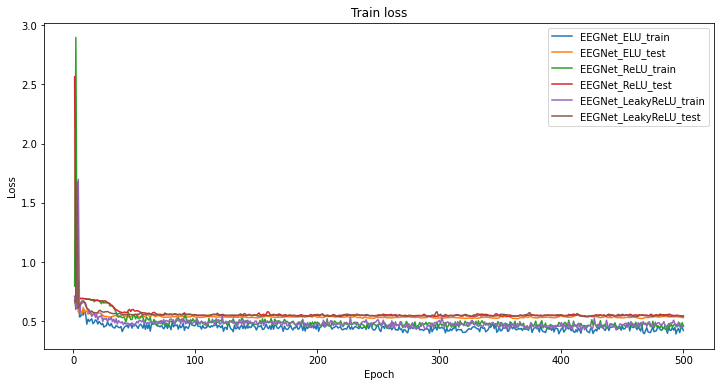

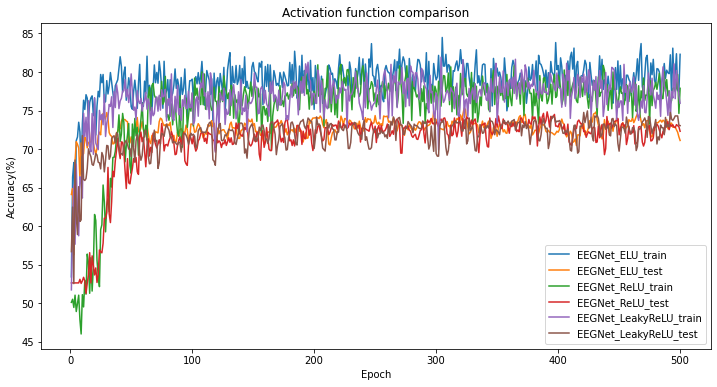

EEGNet_ELU's best accuracy: 0.7533482313156128
EEGNet_ReLU's best accuracy: 0.7483259042104086
EEGNet_LeakyReLU's best accuracy: 0.7495349844296774


In [27]:
BATCH_SIZE: int = 512
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

LEARNING_RATE: float = 1e-2
activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
models = {f"EEGNet_{activation}": EEGNet(activation = activation) for activation in activations}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = 0.1)
loss = nn.CrossEntropyLoss()

EPOCH_SIZE: int = 500
SAVE_WEIGHTS: bool = False
SAVE_FOLDER: str = "models/EEGNet"
EEGNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
EEGNet_trainer.train(models, optimizer_fn, EPOCH_SIZE, save_weights = SAVE_WEIGHTS, folder_path = SAVE_FOLDER)

Training DeepConvNet_ELU model...
epoch: 100, train loss: 0.3636738161245982, train accuracy: 0.8278459906578064, test loss: 0.4659305314222972, test accuracy: 0.7815290292104086
epoch: 200, train loss: 0.2358412742614746, train accuracy: 0.8977864782015482, test loss: 0.5109513401985168, test accuracy: 0.7783668239911398
epoch: 300, train loss: 0.14285175999005637, train accuracy: 0.968563993771871, test loss: 0.5835588872432709, test accuracy: 0.7593006094296774
epoch: 400, train loss: 0.10748701790968578, train accuracy: 0.998046875, test loss: 0.6165293057759603, test accuracy: 0.7370721896489462
epoch: 500, train loss: 0.10233183453480403, train accuracy: 0.9967447916666666, test loss: 0.6796824137369791, test accuracy: 0.7264694968859354
Training DeepConvNet_ReLU model...
epoch: 100, train loss: 0.4384450117746989, train accuracy: 0.7891555229822794, test loss: 0.45564306775728863, test accuracy: 0.8225446542104086
epoch: 200, train loss: 0.3733571072419484, train accuracy: 0.828

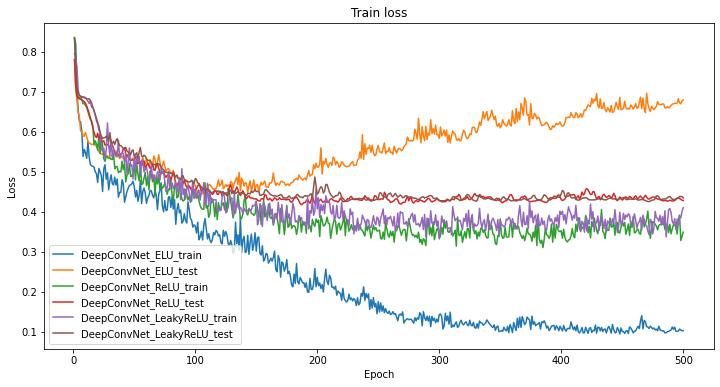

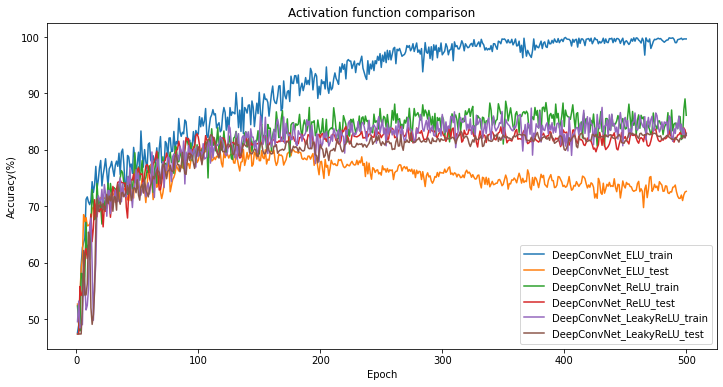

DeepConvNet_ELU's best accuracy: 0.8059896032015482
DeepConvNet_ReLU's best accuracy: 0.8414248625437418
DeepConvNet_LeakyReLU's best accuracy: 0.8335193594296774


In [18]:
BATCH_SIZE: int = 512
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

LEARNING_RATE: float = 1e-3
activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
models = {f"DeepConvNet_{activation}": DeepConvNet(activation = activation) for activation in activations}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = 0.1)
loss = nn.CrossEntropyLoss()

EPOCH_SIZE: int = 500
SAVE_WEIGHTS: bool = True
SAVE_FOLDER: str = "models/DeepConvNet"
DeepConvNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
DeepConvNet_trainer.train(models, optimizer_fn, EPOCH_SIZE, save_weights = SAVE_WEIGHTS, folder_path = SAVE_FOLDER)

## Discussion

> What happened if I increase weight decay to diminish overfitting?

Training EEGNet_ELU model...
epoch: 100, train loss: 0.5214916368325552, train accuracy: 0.7472098271052042, test loss: 0.5599051018555959, test accuracy: 0.710751493771871
epoch: 200, train loss: 0.476757009824117, train accuracy: 0.775576651096344, test loss: 0.5450875659783682, test accuracy: 0.7126116156578064
epoch: 300, train loss: 0.505762000878652, train accuracy: 0.7543712854385376, test loss: 0.5456910729408264, test accuracy: 0.7073102792104086
Training EEGNet_ReLU model...
epoch: 100, train loss: 0.5112801194190979, train accuracy: 0.7282366156578064, test loss: 0.5807495911916097, test accuracy: 0.6889881094296774
epoch: 200, train loss: 0.5135623812675476, train accuracy: 0.7725074489911398, test loss: 0.5715243816375732, test accuracy: 0.6796875
epoch: 300, train loss: 0.5123163163661957, train accuracy: 0.7460007468859354, test loss: 0.572605311870575, test accuracy: 0.6949404875437418
Training EEGNet_LeakyReLU model...
epoch: 100, train loss: 0.511043647925059, train a

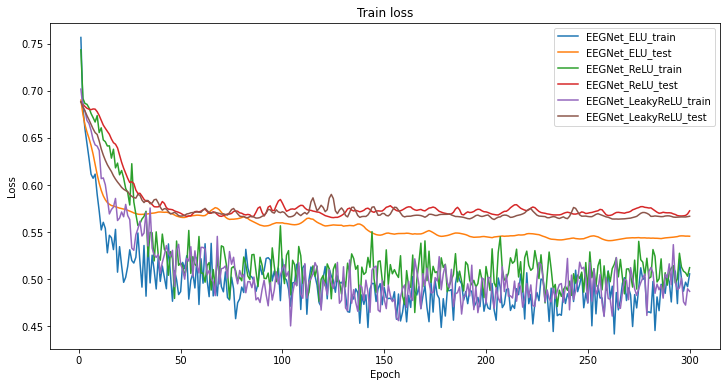

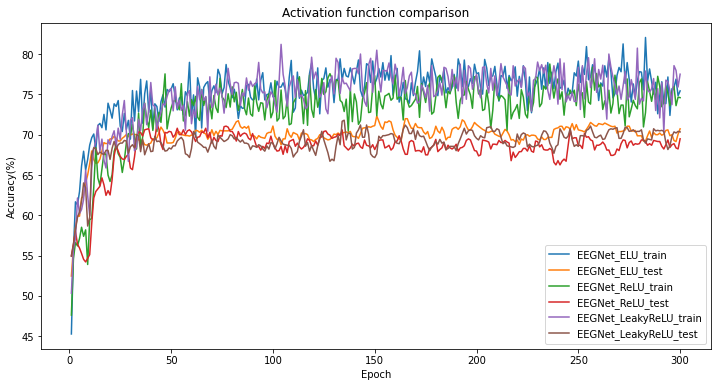

EEGNet_ELU's best accuracy: 0.7233073115348816
EEGNet_ReLU's best accuracy: 0.7140067021052042
EEGNet_LeakyReLU's best accuracy: 0.7180059552192688


In [91]:
BATCH_SIZE: int = 512
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

LEARNING_RATE: float = 1e-3
activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
models = {f"EEGNet_{activation}": EEGNet(activation = activation) for activation in activations}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = 0.3)
loss = nn.CrossEntropyLoss()

EPOCH_SIZE: int = 300
SAVE_WEIGHTS: bool = False
SAVE_FOLDER: str = "models/EEGNet"
EEGNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
EEGNet_trainer.train(models, optimizer_fn, EPOCH_SIZE, save_weights = SAVE_WEIGHTS, folder_path = SAVE_FOLDER)

Training DeepConvNet_ELU model...
epoch: 100, train loss: 0.5075570245583853, train accuracy: 0.740234394868215, test loss: 0.5663193563620249, test accuracy: 0.7041480739911398
epoch: 200, train loss: 0.49714527527491253, train accuracy: 0.7429315646489462, test loss: 0.5618762175242106, test accuracy: 0.711309532324473
epoch: 300, train loss: 0.5162860949834188, train accuracy: 0.7349330385526022, test loss: 0.5689589977264404, test accuracy: 0.707403282324473
epoch: 400, train loss: 0.530777633190155, train accuracy: 0.7410714427630106, test loss: 0.5788244505723318, test accuracy: 0.6612723271052042
epoch: 500, train loss: 0.5556694865226746, train accuracy: 0.7157738208770752, test loss: 0.5757642785708109, test accuracy: 0.6981956958770752
Training DeepConvNet_ReLU model...
epoch: 100, train loss: 0.5262681245803833, train accuracy: 0.7337239782015482, test loss: 0.5623081227143606, test accuracy: 0.7042410771052042
epoch: 200, train loss: 0.5295059680938721, train accuracy: 0.72

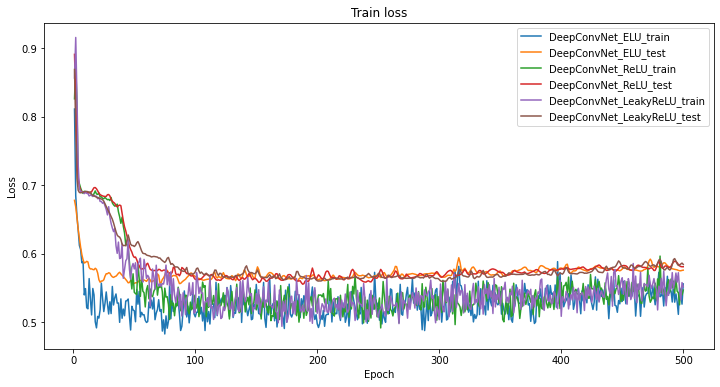

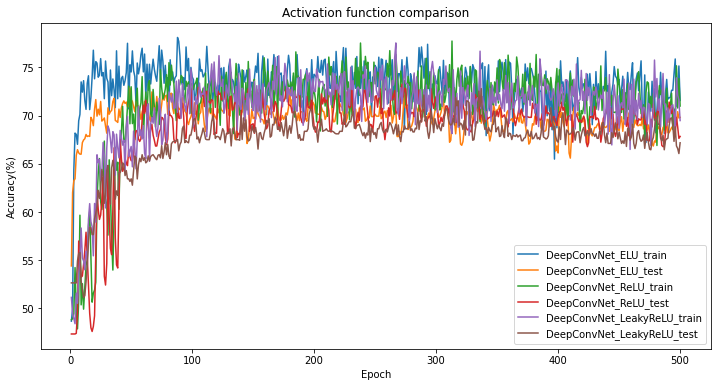

DeepConvNet_ELU's best accuracy: 0.7286086479822794
DeepConvNet_ReLU's best accuracy: 0.7358631094296774
DeepConvNet_LeakyReLU's best accuracy: 0.7280506094296774


In [92]:
BATCH_SIZE: int = 512
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

LEARNING_RATE: float = 1e-3
activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
models = {f"DeepConvNet_{activation}": DeepConvNet(activation = activation) for activation in activations}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = 0.3)
loss = nn.CrossEntropyLoss()

EPOCH_SIZE: int = 500
SAVE_WEIGHTS: bool = False
SAVE_FOLDER: str = "models/DeepConvNet"
DeepConvNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
DeepConvNet_trainer.train(models, optimizer_fn, EPOCH_SIZE, save_weights = SAVE_WEIGHTS, folder_path = SAVE_FOLDER)

> What happened if I use different dropout values?

In [40]:
BATCH_SIZE: int = 512
LEARNING_RATE: float = 1e-3
WEIGHT_DECAY: float = 1e-1
EPOCH_SIZE: int = 500

### EEGNet Dropout = 0.25

Training EEGNet_ELU_dropout=0.25 model...
epoch: 100, train loss: 0.436697781085968, train accuracy: 0.795107901096344, test loss: 0.5595513880252838, test accuracy: 0.7232142885526022
epoch: 200, train loss: 0.3979802330334981, train accuracy: 0.8213355739911398, test loss: 0.5467679301897684, test accuracy: 0.7310267885526022
epoch: 300, train loss: 0.38413990537325543, train accuracy: 0.8094308177630106, test loss: 0.5614841183026632, test accuracy: 0.7356771032015482
epoch: 400, train loss: 0.3681859076023102, train accuracy: 0.8542596896489462, test loss: 0.5585981806119283, test accuracy: 0.7277715802192688
epoch: 500, train loss: 0.38114722569783527, train accuracy: 0.8344494104385376, test loss: 0.545386552810669, test accuracy: 0.7270275354385376
Training EEGNet_ReLU_dropout=0.25 model...
epoch: 100, train loss: 0.4520300626754761, train accuracy: 0.787295401096344, test loss: 0.5799388289451599, test accuracy: 0.708798368771871
epoch: 200, train loss: 0.42670069138209027, tra

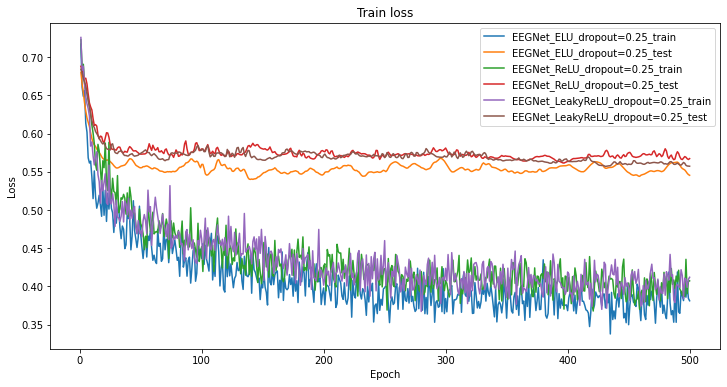

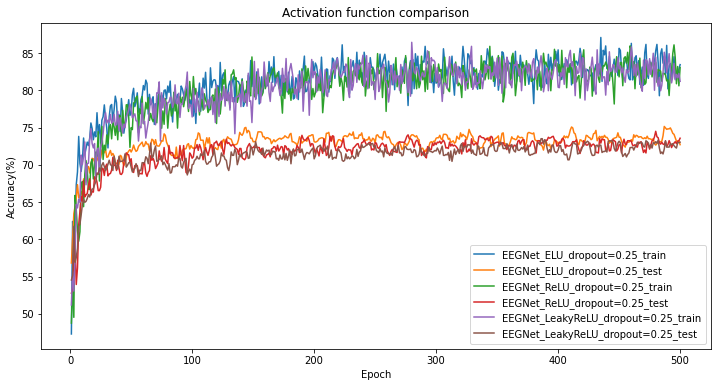

EEGNet_ELU_dropout=0.25's best accuracy: 0.7514881094296774
EEGNet_ReLU_dropout=0.25's best accuracy: 0.7449776927630106
EEGNet_LeakyReLU_dropout=0.25's best accuracy: 0.7350260615348816


In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
dropouts: List[float] = [0.25]
models = {f"EEGNet_{activation}_dropout={dropout}": EEGNet(activation = activation, dropout = dropout) for activation in activations for dropout in dropouts}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = WEIGHT_DECAY)
loss = nn.CrossEntropyLoss()

EEGNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
EEGNet_trainer.train(models, optimizer_fn, EPOCH_SIZE)

### EEGNet Dropout = 0.75

Training EEGNet_ELU_dropout=0.75 model...
epoch: 100, train loss: 0.422068456808726, train accuracy: 0.8049665292104086, test loss: 0.5429292023181915, test accuracy: 0.7290736635526022
epoch: 200, train loss: 0.391684631506602, train accuracy: 0.8299851417541504, test loss: 0.5533880094687144, test accuracy: 0.744140644868215
epoch: 300, train loss: 0.3430149555206299, train accuracy: 0.8662574489911398, test loss: 0.5403430064519247, test accuracy: 0.7513951063156128
epoch: 400, train loss: 0.3701333900292714, train accuracy: 0.8331473271052042, test loss: 0.5522938668727875, test accuracy: 0.752139151096344
epoch: 500, train loss: 0.35896065831184387, train accuracy: 0.8264509042104086, test loss: 0.5467552642027537, test accuracy: 0.7612537344296774
Training EEGNet_ReLU_dropout=0.75 model...
epoch: 100, train loss: 0.4978826443354289, train accuracy: 0.744326651096344, test loss: 0.566157857577006, test accuracy: 0.7119605739911398
epoch: 200, train loss: 0.4546566406885783, train 

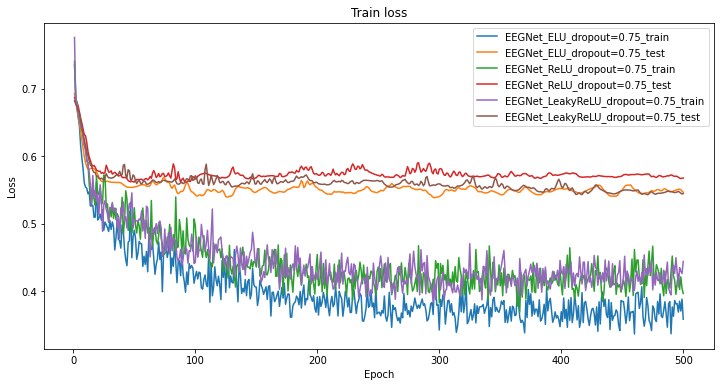

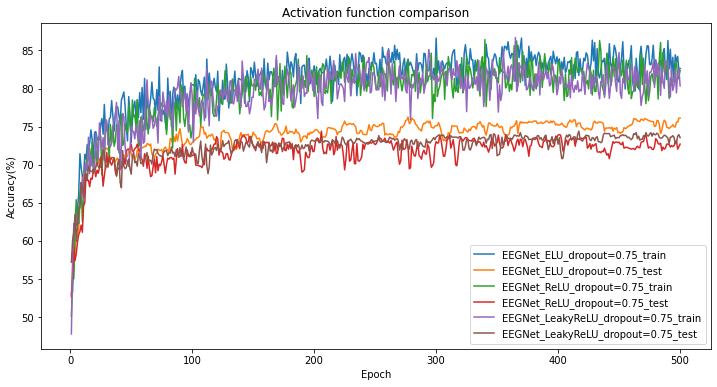

EEGNet_ELU_dropout=0.75's best accuracy: 0.7626488208770752
EEGNet_ReLU_dropout=0.75's best accuracy: 0.744140644868215
EEGNet_LeakyReLU_dropout=0.75's best accuracy: 0.744140644868215


In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
dropouts: List[float] = [0.75]
models = {f"EEGNet_{activation}_dropout={dropout}": EEGNet(activation = activation, dropout = dropout) for activation in activations for dropout in dropouts}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = WEIGHT_DECAY)
loss = nn.CrossEntropyLoss()

EEGNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
EEGNet_trainer.train(models, optimizer_fn, EPOCH_SIZE)

### DeepConvNet Dropout = 0.25

Training DeepConvNet_ELU_dropout=0.25 model...
epoch: 100, train loss: 0.18982102970282236, train accuracy: 0.9365699489911398, test loss: 0.5477818051973978, test accuracy: 0.7665550708770752
epoch: 200, train loss: 0.06382796913385391, train accuracy: 1.0, test loss: 0.7370673418045044, test accuracy: 0.7231212854385376
epoch: 300, train loss: 0.06469982614119847, train accuracy: 0.9993489583333334, test loss: 0.8532381653785706, test accuracy: 0.6862909396489462
epoch: 400, train loss: 0.07896317541599274, train accuracy: 0.9986979166666666, test loss: 0.9202696084976196, test accuracy: 0.658017118771871
epoch: 500, train loss: 0.0725378468632698, train accuracy: 1.0, test loss: 0.9442792137463888, test accuracy: 0.6416480739911398
Training DeepConvNet_ReLU_dropout=0.25 model...
epoch: 100, train loss: 0.45759228865305585, train accuracy: 0.7769717375437418, test loss: 0.4929574429988861, test accuracy: 0.7923177282015482
epoch: 200, train loss: 0.37527401248613995, train accuracy: 

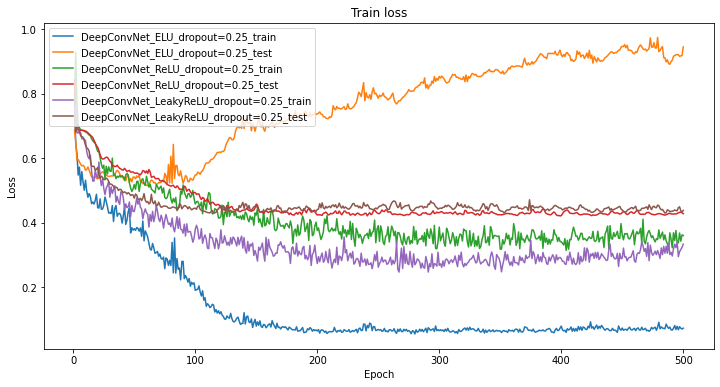

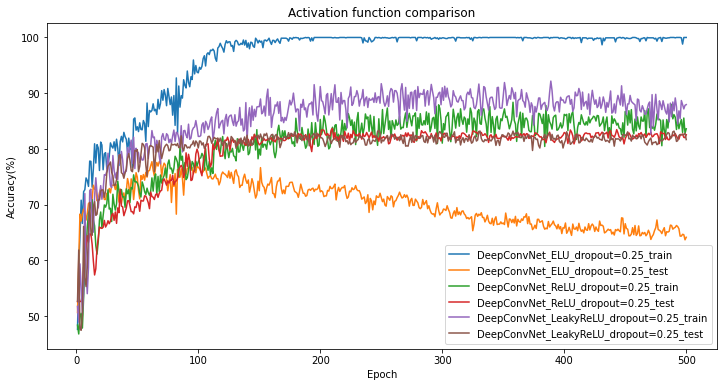

DeepConvNet_ELU_dropout=0.25's best accuracy: 0.7785528500874838
DeepConvNet_ReLU_dropout=0.25's best accuracy: 0.8367745677630106
DeepConvNet_LeakyReLU_dropout=0.25's best accuracy: 0.8334263563156128


In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
dropouts: List[float] = [0.25]
models = {f"DeepConvNet_{activation}_dropout={dropout}": DeepConvNet(activation = activation, dropout = dropout) for activation in activations for dropout in dropouts}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = WEIGHT_DECAY)
loss = nn.CrossEntropyLoss()

DeepConvNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
DeepConvNet_trainer.train(models, optimizer_fn, EPOCH_SIZE)

### DeepConvNet Dropout = 0.75

Training DeepConvNet_ELU_dropout=0.75 model...
epoch: 100, train loss: 0.4497060378392537, train accuracy: 0.7961309750874838, test loss: 0.5578719973564148, test accuracy: 0.7371651927630106
epoch: 200, train loss: 0.429937203725179, train accuracy: 0.802920401096344, test loss: 0.570326010386149, test accuracy: 0.7270275354385376
epoch: 300, train loss: 0.3622637291749318, train accuracy: 0.8053385615348816, test loss: 0.5930880109469095, test accuracy: 0.7192150354385376
epoch: 400, train loss: 0.27743445833524066, train accuracy: 0.8897879521052042, test loss: 0.6543043653170267, test accuracy: 0.7138206958770752
epoch: 500, train loss: 0.20608715216318765, train accuracy: 0.9496837854385376, test loss: 0.6960811217625936, test accuracy: 0.7080543239911398
Training DeepConvNet_ReLU_dropout=0.75 model...
epoch: 100, train loss: 0.4969589114189148, train accuracy: 0.736142118771871, test loss: 0.5520772834618887, test accuracy: 0.7053571542104086
epoch: 200, train loss: 0.42442327737

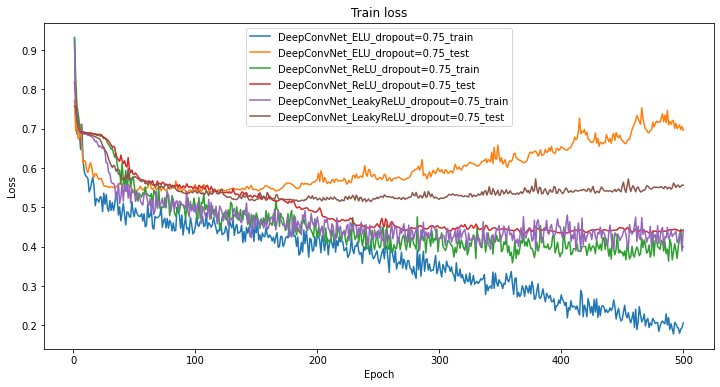

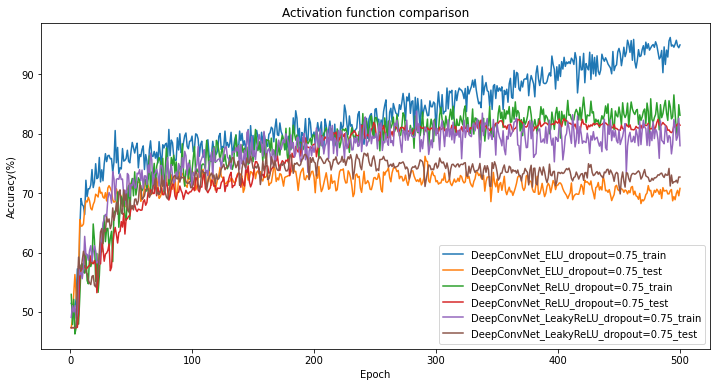

DeepConvNet_ELU_dropout=0.75's best accuracy: 0.762090782324473
DeepConvNet_ReLU_dropout=0.75's best accuracy: 0.8256138563156128
DeepConvNet_LeakyReLU_dropout=0.75's best accuracy: 0.7672991156578064


In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

activations: List[str] = ["ELU", "ReLU", "LeakyReLU"]
dropouts: List[float] = [0.75]
models = {f"DeepConvNet_{activation}_dropout={dropout}": DeepConvNet(activation = activation, dropout = dropout) for activation in activations for dropout in dropouts}
optimizer_fn = lambda params: torch.optim.Adam(params, lr = LEARNING_RATE, betas = (0.9, 0.999), weight_decay = WEIGHT_DECAY)
loss = nn.CrossEntropyLoss()

DeepConvNet_trainer = Trainer(loss, train_dataloader, test_dataloader)
DeepConvNet_trainer.train(models, optimizer_fn, EPOCH_SIZE)

## Demo

In [19]:
def test(model: Model, data_loader: DataLoader):
    accuracy = 0
    batch_size = len(data_loader)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()
    for x, y in data_loader:
        x, y = x.float().to(device), y.long().to(device)
        y_pred = model(x)

        accuracy += Trainer._calculate_accuracy(y_pred, y)

    accuracy /= batch_size
    return accuracy

In [26]:
BATCH_SIZE: int = 512
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

activation = "ELU"
eegNet = EEGNet(activation = activation)
eegNet.load_state_dict(torch.load("models/EEGNet/EEGNet_ELU_epoch_325.pth"))
print(eegNet)
print(f"Accuracy of EEGNet with {activation}:", test(eegNet, test_dataloader))

activation = "ReLU"
deepConvNet = DeepConvNet(activation = activation)
deepConvNet.load_state_dict(torch.load("models/DeepConvNet/DeepConvNet_ReLU_epoch_221.pth"))
print(deepConvNet)
print(f"Accuracy of DeepConvNet with {activation}:", test(deepConvNet, test_dataloader))

EEGNet(
  (first_conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwise_conv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separable_conv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classfier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=736, out

In [18]:
m = nn.Dropout(p=0.5)
input = torch.randn(20, 16)
m(input)

tensor([[-2.1304e+00, -7.9590e-01,  0.0000e+00,  0.0000e+00, -1.0393e-01,
          5.4800e+00, -0.0000e+00, -8.4136e-01, -0.0000e+00, -0.0000e+00,
          0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  2.4838e+00,
         -1.9165e+00],
        [ 1.1867e+00,  0.0000e+00,  7.4928e-01, -0.0000e+00, -0.0000e+00,
          0.0000e+00, -9.1545e-01, -3.8675e-01, -0.0000e+00,  2.5990e+00,
         -0.0000e+00, -5.2334e-02,  0.0000e+00,  0.0000e+00,  1.1606e+00,
          0.0000e+00],
        [ 0.0000e+00, -2.2126e-02, -0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.3243e+00,  0.0000e+00, -0.0000e+00, -2.2548e+00, -2.7083e+00,
          2.2126e+00,  0.0000e+00, -2.4069e+00,  0.0000e+00,  0.0000e+00,
         -0.0000e+00],
        [ 0.0000e+00,  8.8707e-02, -6.0556e-01, -0.0000e+00,  1.4808e+00,
         -1.8753e+00,  8.0206e-02,  0.0000e+00, -8.9944e-02,  0.0000e+00,
         -0.0000e+00,  1.5184e+00,  0.0000e+00,  1.7637e+00,  2.1865e+00,
          0.0000e+00],
        [-4.0924e+00